In [1]:
import numpy as np
from tqdm import tqdm
import os
import matplotlib.pyplot as plt
import cv2

import sys
# Get the previous folder and append it to sys.path
PATH = os.path.abspath(os.path.join(os.getcwd(), '..'))
sys.path.append(PATH)

from config import DATAFOLDER

In [2]:
dataset = 'Thebe'

split = 'val'  # train, val
ps = 256 # patch size
step = 3 # step size
stride = ps // 2

min_per = 3 # minimum % of fault pixels
pixels = int(min_per/100*ps*ps)

In [3]:
DATAPATH = os.path.join(DATAFOLDER, dataset)
DATAPATH2D = os.path.join(DATAPATH, 'Patches2D', 'src_ps{}to128_step{}'.format(ps, step) )
DATAPATH2D

'C:\\Users\\Usuario\\Documents\\Mestrado\\Tesis\\src\\datasets\\Thebe\\Patches2D\\src_ps256to128_step3'

## Read data

In [4]:
ld = os.listdir(DATAPATH)
ld = [x for x in ld if 'fault' + split in x ]
ld

['faultval1.npy', 'faultval2.npy']

In [5]:
faults = []
seismic = []

for i in tqdm(range(len(ld))):
    i=i+1
    
    fault = np.load('{}/fault{}{}.npy'.format(DATAPATH, split, i))
    seis = np.load('{}/seis{}{}.npy'.format(DATAPATH, split, i))
    
    faults.append(fault)
    seismic.append(seis)
    
    del fault
    
faults = np.vstack(faults)
seismic = np.vstack(seismic)

100%|████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:05<00:00,  2.93s/it]


In [6]:
faults.shape, seismic.shape   # IL, XL, Z

((200, 3174, 1537), (200, 3174, 1537))

### Pre-Processing

In [7]:
# make it IL, Z, XL order
seismic = np.moveaxis(seismic,-2,-1) 
faults = np.moveaxis(faults,-2,-1)

seismic.shape, faults.shape

((200, 1537, 3174), (200, 1537, 3174))

In [8]:
# scaling
mean_ = seismic.mean(axis=(1,2), keepdims=True)
std_ = seismic.std(axis=(1,2), keepdims=True)

print(mean_.shape)

seismic = (seismic - mean_)/std_

(200, 1, 1)


## Patch Generation

In [9]:
from dataloaders import PatchGenerator

seismic_slide = seismic[0]
h, w = seismic_slide.shape

patch_generator = PatchGenerator((h,w), ps, stride, phase='train')

nx, left_pad, right_pad, ny, top_pad, bottom_pad
24 13 13 12 63 64


In [10]:
fault_patches_total = []
seismic_patches_total = []
for il in tqdm(range(0, seismic.shape[0], step)):
    seismic_slide = seismic[il]
    fault_slide = faults[il]
    
    seismic_patches = patch_generator.get_patches(seismic_slide) #get_patches(seismic_slide, ps, stride)
    fault_patches = patch_generator.get_patches(fault_slide) #get_patches(fault_slide, ps, stride)
    
    seismic_patches = seismic_patches[fault_patches.sum((1,2)) >= pixels]
    fault_patches = fault_patches[fault_patches.sum((1,2)) >= pixels]
    
    seismic_patches_total.append(seismic_patches)
    fault_patches_total.append(fault_patches)
    
seismic_patches_total = np.vstack(seismic_patches_total)
fault_patches_total = np.vstack(fault_patches_total)
seismic_patches_total.shape, fault_patches_total.shape

100%|██████████████████████████████████████████████████████████████████████████████████| 67/67 [00:04<00:00, 14.34it/s]


((4371, 256, 256), (4371, 256, 256))

In [11]:
# resize 256 to 128

new_size = (128, 128)

seismic_patches_total_2 = [np.expand_dims(cv2.resize(patch, new_size), axis=0) for patch in seismic_patches_total]
fault_patches_total_2 = [np.expand_dims(cv2.resize(patch.astype(float), new_size, interpolation=cv2.INTER_NEAREST), axis=0) for patch in fault_patches_total]

seismic_patches_total = np.vstack(seismic_patches_total_2)
fault_patches_total = np.vstack(fault_patches_total_2)

seismic_patches_total.shape, fault_patches_total.shape

((4371, 128, 128), (4371, 128, 128))

### Ploting some of them

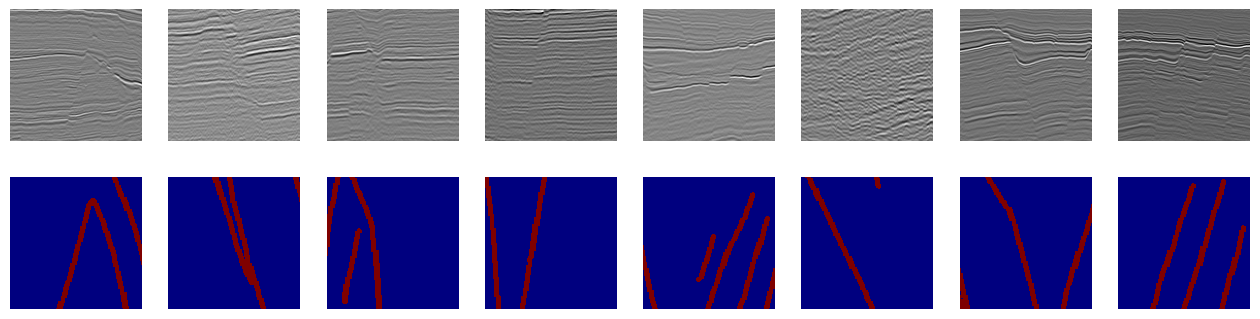

In [12]:
fig, axes = plt.subplots(2, 8, figsize=[16,4])
for i in range(8):
    ix = np.random.choice(len(seismic_patches_total))
    axes[0, i].imshow(seismic_patches_total[ix], cmap="gray")
    axes[1, i].imshow(fault_patches_total[ix], cmap="jet", interpolation="nearest")
    axes[0, i].axis('off')
    axes[1, i].axis('off')

### Saving

In [13]:
dir_imgs = "{}/{}/seismic".format(DATAPATH2D, split)
if not os.path.exists(dir_imgs):
    os.makedirs(dir_imgs)
    
dir_mask = "{}/{}/faults".format(DATAPATH2D, split)
if not os.path.exists(dir_mask):
    os.makedirs(dir_mask)

In [14]:
for i in tqdm(range(len(seismic_patches_total))):
    np.save("{}/{}.npy".format(dir_imgs, i), seismic_patches_total[i])
    np.save("{}/{}.npy".format(dir_mask, i), fault_patches_total[i])

100%|████████████████████████████████████████████████████████████████████████████| 4371/4371 [00:04<00:00, 1043.53it/s]
